**Copyright 2019 The TensorFlow Authors.**

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 텐서플로우 모델 생성 및 변환
이 노트북을 통해 TensorFlow 모델을 작성한 뒤 어떻게 TensorFlow Lite 모델로 변환하는지를 살펴볼 것입니다. 이 노트북에서 생성된 모델은 [TensorFlow Lite for Microcontrollers](https://www.tensorflow.org/lite/microcontrollers/overview)의 [hello_world](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/lite/micro/examples/hello_world)샘플에서도 사용됩니다.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/lite/micro/examples/hello_world/create_sine_model.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/micro/examples/hello_world/create_sine_model.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>


## 종속성 로드
가장 먼저 해야할 일은 우리가 필요한 종속성을 로드하는 것이다. 아래의 셀을 실행해보자. 

In [2]:
# TensorFlow는 오픈소스 라이브러리다. 
# 참조: 아래의 코드는 텐서플로우 2버전을 사용함. 
!pip install tensorflow==2.0.0-beta0
import tensorflow as tf
# 넘파이(Numpy)는 수학 연산에 추가적으로 필요한 라이브러리이다. 
import numpy as np
# Matplotlib은 그래프를 그리는데 필요한 라이브러리이다. 
import matplotlib.pyplot as plt
# math는 파이썬의 수학 라이브러리이다. 
import math

ERROR: Could not find a version that satisfies the requirement tensorflow==2.0.0-beta0 (from versions: 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.16.0rc0)
ERROR: No matching distribution found for tensorflow==2.0.0-beta0


## 데이터 생성하기
딥러닝 네트워크는 데이터에서 패턴을 학습한다. 여기서는 [싸인함수](https://en.wikipedia.org/wiki/Sine)로 생성된 데이터를 모델링하기 위해 네트워크를 훈련한다. 훈련을 마치면 값`x`를 입력받아 `y`를 예측할 수있는 모델이 생성되는데, 사실 우리는 이미 싸인함수 공식을 알고 있기 때문에 필요하면 직접 계산할 수 있다. 그렇지만 지금은 모델 훈련을 위한 데이터가 어떤 패턴을 지니고 있는지 모르는 상태에서 모델을 훈련한다고 하자.

TensorFlow Lite for Microcontrollers의 hello_world 샘플의 경우, 이 모델을 사용하여 LED가 순서대로 점등되도록 제어한다.

다음 셀의 코드는 임의의 `x`값 세트를 생성하고 사인 값을 계산하여 그래프에 표시한다:

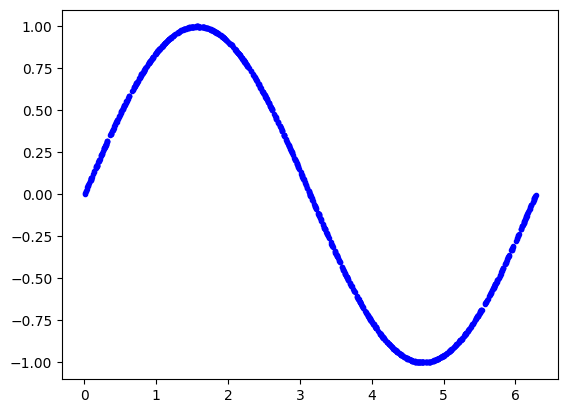

In [3]:
# 아래의 값만큼 데이터 샘플을 생성할 것이다. 
SAMPLES = 1000

# 시드 값을 지정하여 이 노트북에서 실행할 때마다 다른 랜덤 값을 얻게 한다. 
# 어떤 숫자든 사용할 수 있다. 
np.random.seed(1337)

# 사인파 진폭의 범위인 0~2π 내에서 균일하게 분포된 난수 집합을 생성한다.
x_values = np.random.uniform(low=0, high=2*math.pi, size=SAMPLES)

# 값을 섞어서 생성된 값들이 순서를 따르지 않도록 한다. 
np.random.shuffle(x_values)

# 해당 사인값을 계산한다
y_values = np.sin(x_values)

# 데이터를 그래프로 그린다. 'b.' 인수는 라이브러리에 점을 파란색으로 출력하도록 지시한다.
plt.plot(x_values, y_values, 'b.')
plt.show()

## 노이즈 추가

사인 함수에 의해 직접 생성되었으므로 데이터는 훌륭하고 부드러운 곡선으로 나타난다. 

그러나 머신 러닝 모델은 보다 복잡한 실제 데이터에서 패턴을 알아낼 수 있다. 이를 위해 데이터에 약간의 노이즈를 추가하여 보다 실제와 비슷한 데이터를 만들어보자.

다음 셀에서는 각 값에 임의의 노이즈를 추가 한 다음 새 그래프를 그린다.

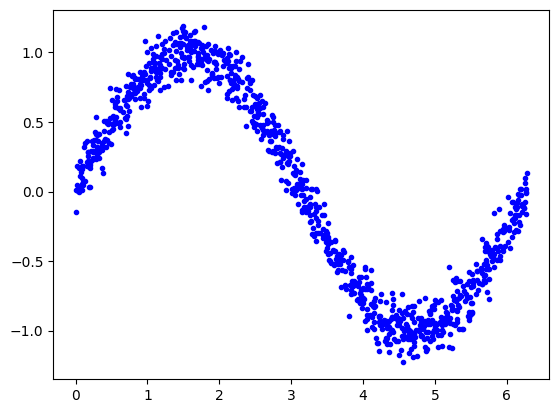

In [4]:
# 각 y 값에 임의의 작은 숫자를 추가한다. 
y_values += 0.1 * np.random.randn(*y_values.shape)

# 그래프를 생성한다. 
plt.plot(x_values, y_values, 'b.')
plt.show()

## 데이터 분할
이제 실제 데이터와 비슷한 노이즈가 추가된 데이터 세트가 생성되었다. 우리는 이 데이터를 모델을 훈련시키기 위해 사용할 것입니다.

우리가 훈련시키는 모델의 정확성을 평가하려면 예측을 실제 데이터와 비교하고 일치하는 정도를 확인해야한다. 이 평가는 훈련중(검증이라고 함)과 훈련후(테스트라고 함)발생한다. 두 경우 모두 모델 훈련에 사용되지 않은 새로운 데이터를 사용하는 것이 중요하다.

평가에 사용할 데이터를 확보하기 위해 훈련을 시작하기 전에 따로 분할하도록 하자. 검증셋에 20%, 테스트셋에 20%를 미리 할당해두자. 나머지 60%는 모델 학습에 사용된다. 이는 모델을 훈련 할 때 사용되는 일반적인 데이터 분할이다.

다음 코드는 데이터를 분할 한 다음 각 세트를 다른 색상으로 그래프에 나타낸다.

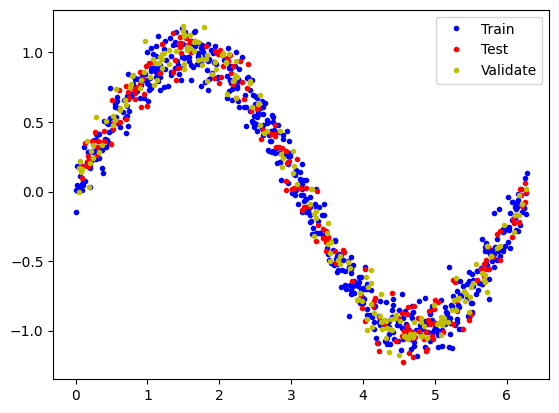

In [5]:
# 훈련에 60%, 테스트에 20%, 검증에  20%를 사용한다. 
# 각 항목의 인덱스를 계산한다.
TRAIN_SPLIT =  int(0.6 * SAMPLES)
TEST_SPLIT = int(0.2 * SAMPLES + TRAIN_SPLIT)

# np.split을 사용하여 데이터를 세 부분으로 자른다. 
# np.split의 두 번째 인수는 데이터가 분할되는 인덱스 배열이며,
# 우리는 두 개의 인덱스를 제공하므로 데이터는 세 개의 덩어리로 나뉠 것이다.
x_train, x_test, x_validate = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_test, y_validate = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])

# 분할한 데이터를 합쳤을 때 원래의 사이즈와 같은지 재확인한다.
assert (x_train.size + x_validate.size + x_test.size) ==  SAMPLES

# 분할된 각 데이터들을 다른 색상으로 그래프에 표시한다. 
plt.plot(x_train, y_train, 'b.', label="Train")
plt.plot(x_test, y_test, 'r.', label="Test")
plt.plot(x_validate, y_validate, 'y.', label="Validate")
plt.legend()
plt.show()


## 모델 설계
지금부터 입력값(`x`)을 받아 출력값(`x`의 사인)을 예측하는 모델을 만들 것이다. 이러한 유형의 문제를 회귀_regression_라고 한다.

이를 위해 간단한 신경망을 만들텐데, 뉴런_neurons_과 레이어_layers_를 사용하여 훈련 데이터의 기본적인 패턴을 학습을 통해 예측을 수행해보자.

먼저 두 개의 레이어를 정의하자. 첫 번째 레이어는 단일 입력(`x`값)을 가져와 16개의 뉴런을 통해 활성화된다. 이 입력에 따라 각 뉴런은 내부 상태 (가중치_weight_ 및 편향_bias_값)에 따라 어느정도까지 활성화_activated_된다. 뉴런의 활성화 정도는 숫자로 표현된다.

첫 번째 레이어의 활성화 정도는 두 번째 레이어에 입력으로 공급된다. 이 입력에 자체 가중치와 바이어스를 적용하고 활성화 정도를 계산하여 `y`값으로 출력한다.

**참고:** 신경망의 기능에 대해 자세히 알아 보려면 [Learn TensorFlow](https://codelabs.developers.google.com/codelabs/tensorflow-lab1-helloworld) 코드 랩을 살펴보십시오.

다음 셀의 코드는 딥러닝 네트워크를 만들기위한 TensorFlow의 고수준 API인 [Keras](https://www.tensorflow.org/guide/keras)를 사용하여 모델을 정의한다. 일단 네트워크가 정의되면, 우리는 훈련 방법을 결정하는 파라미터를 지정하여 컴파일_compile_을 진행한다:

In [6]:
# 간단한 모델 구조를 만들기 위해 케라스를 사용한다. 
from tensorflow.keras import layers
model_1 = tf.keras.Sequential()

# 첫 번째 레이어는 16 개의 뉴런을 통해 스칼라Scalar 입력을 받아 다음 레이어에 전달한다. 
# 뉴런은 'relu' 활성화 함수에 따라 값을 전달할지 말지를 결정하게 된다.
model_1.add(layers.Dense(16, activation='relu', input_shape=(1,)))

# 마지막 레이어는 하나의 뉴런인데, 원하는 결과값이 하나의 값이기 때문이다.
model_1.add(layers.Dense(1))

# 표준 옵티마이저와 손실을 사용하여 회귀 모델을 컴파일한다.
model_1.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

## 모델 훈련하기
모델을 정의한 후에는 데이터를 사용하여 훈련_train_할 수 있다. 훈련은 신경망에 x값을 전달하고 네트워크의 출력이 예상되는 y값에서 얼마나 멀리 떨어져 있는지 확인하고 다음에 출력이 더 정확할 수 있도록 뉴런의 가중치와 바이어스를 조정한다.

훈련은 이 프로세스를 전체 데이터 세트에서 여러 번에 걸쳐 실행되는데, 해당 횟수를 에포크_epoch_라고 한다. 훈련중에 실행할 에포크 수는 우리가 설정할 수 있는 파라미터다. 

각 에포크 동안 데이터는 여러 배치_batches_네트워크를 통해 실행된다. 네트워크의 가중치와 바이어스는 매 배치마다 한 번씩 조정되며, 배치크기_batch size_도 우리가 설정할 수 있는 파라미터이다.

다음 셀의 코드는 학습 데이터의 `x` 및`y` 값을 사용하여 모델을 학습시킨다. 1000 에포크_epochs_에 배치 사이즈는_batch_ 16이며 검증_validation_에 사용할 데이터도 전달된다. 셀을 실행하면 훈련을 완료하는 데 시간이 걸릴 수 있다.



In [7]:
# 모델 훈련 
history_1 = model_1.fit(x_train, y_train, epochs=1000, batch_size=16,
                    validation_data=(x_validate, y_validate))

Epoch 1/1000


38/38 [==============================] - 1s 7ms/step - loss: 0.4811 - mae: 0.5693 - val_loss: 0.4433 - val_mae: 0.5655
Epoch 2/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.3666 - mae: 0.5253 - val_loss: 0.4045 - val_mae: 0.5518
Epoch 3/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.3335 - mae: 0.5030 - val_loss: 0.3712 - val_mae: 0.5332
Epoch 4/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.3045 - mae: 0.4819 - val_loss: 0.3443 - val_mae: 0.5184
Epoch 5/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.2799 - mae: 0.4637 - val_loss: 0.3080 - val_mae: 0.4837
Epoch 6/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.2581 - mae: 0.4461 - val_loss: 0.2826 - val_mae: 0.4641
Epoch 7/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.2381 - mae: 0.4288 - val_loss: 0.2597 - val_mae: 0.4467
Epoch 8/1000
38/38 [==============================] - 0s 3ms/step - loss: 

## 훈련 지표 확인
훈련 중에 모델의 성능은 훈련 데이터와 이전에 따로 설정한 유효성 검사 데이터에 대해 지속적으로 측정된다. 다음은 훈련 과정에서 모델의 성능이 어떻게 변했는지 알려주는 데이터 로그중 일부를 그래프로 표시한 것이다.

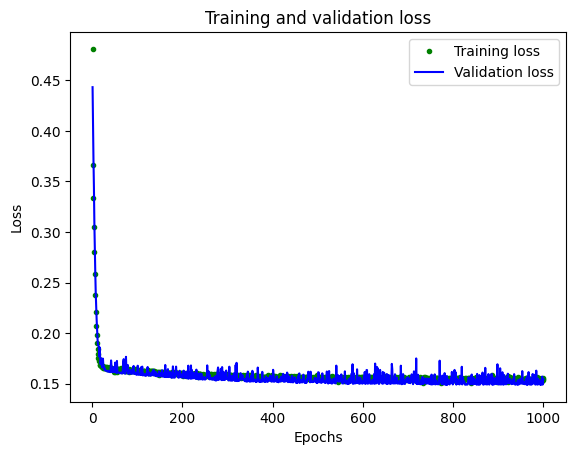

In [8]:
# 훈련과 검증 과정에서 예측값과 실제값 사이의 거리인 손실 그래프를 그린다.
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 데이터 살펴보기
그래프는 각 에포크에 대한 손실값_loss_(또는 모델의 예측과 실제 데이터의 차이)를 보여준다. 손실을 계산하는 방법에는 여러 가지가 있으며, 우리가 사용한 방법은 평균제곱오차_mean squared error_이다. 훈련 및 검증 데이터에 대해 손실값을 확인할 수 있다. 

보시다시, 손실량은 평평 해지기 전에 처음 25개 에포크에서 급속히 감소한다. 이는 모델이 보다 개선되어 정확한 예측을 수행하고 있음을 의미한다!

우리의 목표는 모델이 더 이상 개선되지 않거나 훈련 손실값_training loss_이 검증 손실값_validation loss_보다 작을 때 훈련을 중단하는 것이다. 이는 모델이 더 이상 새로운 데이터로 일반화 할 수 없도록 훈련 데이터를 잘 예측하는 법을 배웠음을 의미한다.

그래프의 평평한 부분을 보다 읽기 쉽게하기 위해 처음 50에포크를 제외해보자.

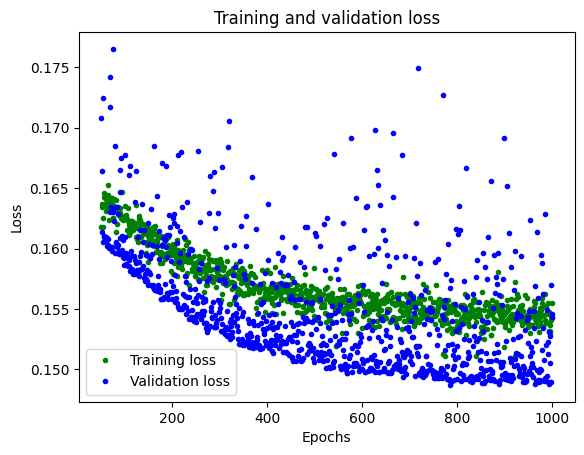

In [9]:
# 그래프를 보기 쉽도록 처음 몇 에폭을 제외.
SKIP = 50

plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 추가 지표 활용
그래프에서 우리는 약 600 에폭까지 손실이 계속 감소하고 이 이후부터 안정적인 움직임을 보이는 것을 알 수 있다. 이는 600에폭이 넘어가면 네트워크를 훈련시킬 필요가 없음을 의미한다.

그러나 가장 낮은 손실 값이 여전히 약 0.155임을 알 수 있다. 이는 우리 네트워크 예측이 평균 ~15% 떨어져 있다는 것을 의미한다. 

모델 성능에 대한 통찰력을 얻기 위해 더 많은 그래프를 그려볼 수 있는데, 이번에는 평균절대오차를 사용할 것이다. 이는 네트워크 예측이 실제 수치와 얼마나 멀리 떨어져 있는지 측정하는 또 다른 방법이다.

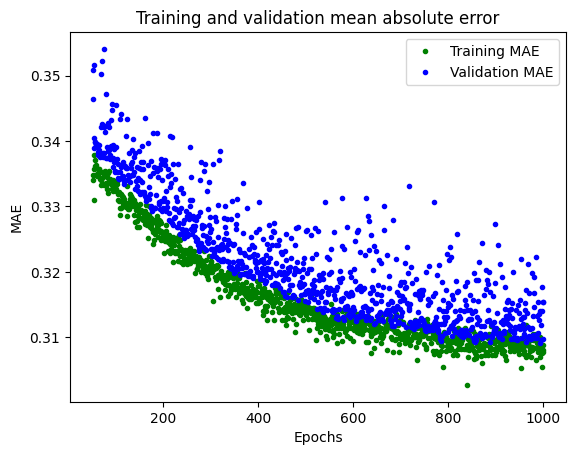

In [10]:
plt.clf()

# 예측에서 오차의 양을 측정하는 또 다른 방법인 평균 절대 오차 그래프를 그린다.
mae = history_1.history['mae']
val_mae = history_1.history['val_mae']

plt.plot(epochs[SKIP:], mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

평균절대오차_mean absolute error_ 그래프는 모델의 다른 측면을 알려준다. 훈련데이터에 비해 검증 데이터에서 보다 일관되게 오류가 높다는 것인데, 이는 네트워크에 과적합_overfit_이 있거나 훈련 데이터를 너무 학습하여 새로운 데이터에 대해 효과적으로 예측을 할 수 없음을 의미한다.

또한 평균 절대 오차 값은 ~0.305로 매우 높으며, 이는 일부 모델의 예측이 30% 이상 떨어져 있음을 의미한다. 30%오류는 사인파 함수를 정확하게 모델링하는 것과는 거리가 멀다는 것을 의미한다.

무슨일이 일어나고 있는지에 알아보기 위해 예측값을 그래프로 나타내보자.

19/19 [==============================] - 0s 2ms/step


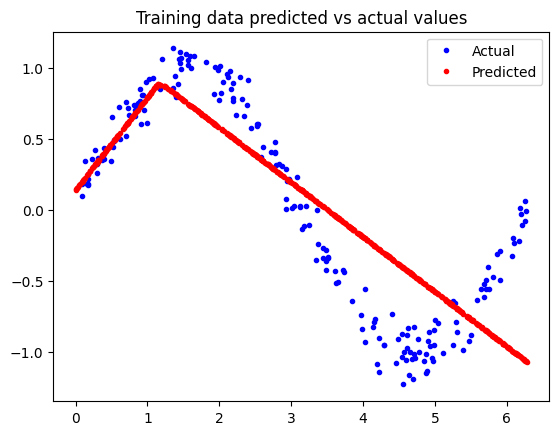

In [11]:
# 모델을 사용하여 검증 데이터로부터 예측값 생성
predictions = model_1.predict(x_train)

# 테스트 데이터와 함께 예측값을 그래프로 표현
plt.clf()
plt.title('Training data predicted vs actual values')
plt.plot(x_test, y_test, 'b.', label='Actual')
plt.plot(x_train, predictions, 'r.', label='Predicted')
plt.legend()
plt.show()

이런! 그래프는 우리 모델이 사인 함수를 매우 제한된 방식으로만 예측한다는 걸 보여준다. 0<=x<=1.1에서 선은 대부분 적합하지만 나머지의 경우 부적절한 것으로 보인다.

왜 그럴까? 이 경우, 모델에 사인파 함수의 전체 복잡성을 학습할 수있는 충분한 Capacity가 없기 때문에 지나치게 단순한 방식으로만 예측을 수행한다. 모델을 더 크게 만들면 Capacity가 늘어나고 성능은 향상될 것이다.

## 퍼셉트론
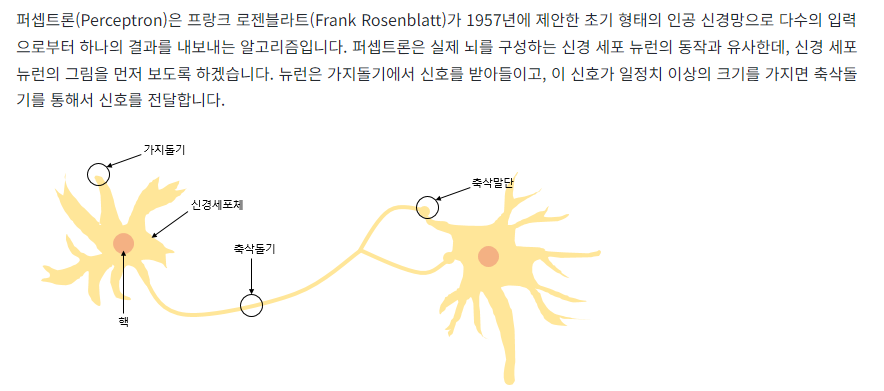

퍼셉트론은 단층 퍼셉트론과 다층 퍼셉트론으로 나누어집니다.

### 단층 퍼셉트론(SLP)
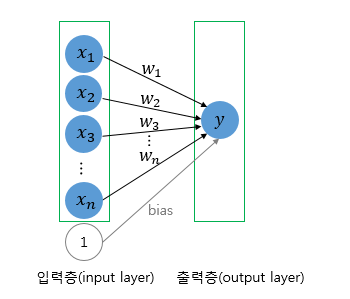

단층 퍼셉트론은 인공신경망의 가장 기초적인 형태로, 입력층(input layer)과 출력층(output layer), 두 개의 층으로만 구성됩니다. 

#### 기존 and게이트의 표현 방식
```
def AND_gate(x1, x2):
    if x1 == 1 and x2 == 1:
        return 1
    else:
        return 0
```

#### 머신러닝에서의 and게이트 표현 방식
```
def AND_gate(x1, x2):
    w1 = 0.5
    w2 = 0.5
    b = -0.7
    result = x1*w1 + x2*w2 + b
    if result <= 0:
        return 0
    else:
        return 1
```

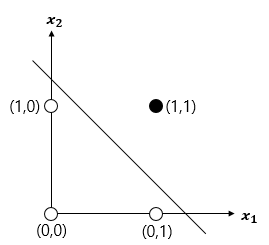
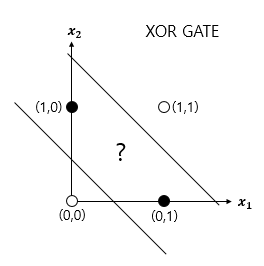

### 다층 퍼셉트론 (MLP)

다층 퍼셉트론은 입력층(input layer), 하나 이상의 은닉층(hidden layers), 그리고 출력층(output layer)으로 구성되어 각 뉴런에서 가중치 합산과 비선형 활성화 함수를 통해 신호를 처리하고, 이러한 과정을 통해 **복잡한 패턴이나 데이터의 특징을 학습**할 수 있습니다.

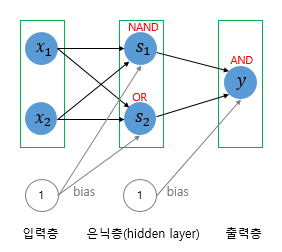


## 모델 변경

모델을 더 크게 만들기 위해 레이어를 추가할 것이다. 다음 셀은 이전과 같은 방식으로 모델을 재정의하지만 중간에 16개의 뉴런이 추가로 있다.

In [12]:
model_2 = tf.keras.Sequential()

# 첫 번째 레이어는 스칼라 입력을 받아 16개의 뉴런을 통해 전달하고, 
# 뉴런은 ‘relu’ 활성화 함수에 따라 활성화 여부를 결정한다.
model_2.add(layers.Dense(16, activation='relu', input_shape=(1,)))

# 새로운 두 번째 레이어는 네트워크가 더 복잡한 표현을 배우는 데 도움을 준다.
model_2.add(layers.Dense(16, activation='relu'))ㄴ

# 단일 값을 출력해야 하기 때문에 최종 레이어는 단일 뉴런으로 구성된다.
model_2.add(layers.Dense(1))

# 표준 옵티마이저 및 손실 함수를 사용하여 회귀 모델을 컴파일
model_2.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

우리는 이제 새로운 모델을 훈련시킬 것이다. 시간을 절약하기 위해 600 에포크만 훈련하자.

In [13]:
history_2 = model_2.fit(x_train, y_train, epochs=600, batch_size=16,
                    validation_data=(x_validate, y_validate))

Epoch 1/600
38/38 [==============================] - 1s 9ms/step - loss: 0.3892 - mae: 0.5455 - val_loss: 0.4054 - val_mae: 0.5431
Epoch 2/600
38/38 [==============================] - 0s 2ms/step - loss: 0.3229 - mae: 0.4936 - val_loss: 0.3409 - val_mae: 0.5060
Epoch 3/600
38/38 [==============================] - 0s 2ms/step - loss: 0.2745 - mae: 0.4550 - val_loss: 0.2863 - val_mae: 0.4624
Epoch 4/600
38/38 [==============================] - 0s 2ms/step - loss: 0.2316 - mae: 0.4186 - val_loss: 0.2387 - val_mae: 0.4247
Epoch 5/600
38/38 [==============================] - 0s 2ms/step - loss: 0.1999 - mae: 0.3872 - val_loss: 0.2036 - val_mae: 0.3934
Epoch 6/600
38/38 [==============================] - 0s 2ms/step - loss: 0.1766 - mae: 0.3635 - val_loss: 0.1794 - val_mae: 0.3680
Epoch 7/600
38/38 [==============================] - 0s 2ms/step - loss: 0.1637 - mae: 0.3461 - val_loss: 0.1691 - val_mae: 0.3527
Epoch 8/600
38/38 [==============================] - 0s 2ms/step - loss: 0.1569 - m

## 새 모델 평가하기
각 에포크 마다 모델은 훈련 및 검증셋에 대한 손실 및 평균 절대 오차를 출력한다. (정확한 숫자는 다를 수 있다).

```
Epoch 600/600
600/600 [==============================] - 0s 109us/sample - loss: 0.0124 - mae: 0.0892 - val_loss: 0.0116 - val_mae: 0.0845
```

여기에서 모델이 크게 개선된 것을 확인할 수 있다. 검증 손실이 0.15에서 0.015로, 검증 MAE가 0.31에서 0.1로 떨어졌다.

다음 셀은 원래 모델을 평가하는 데 사용한 것과 동일한 그래프를 출력하지만 새로 훈련한 모델을 사용한 데이터를 보여줍니다.

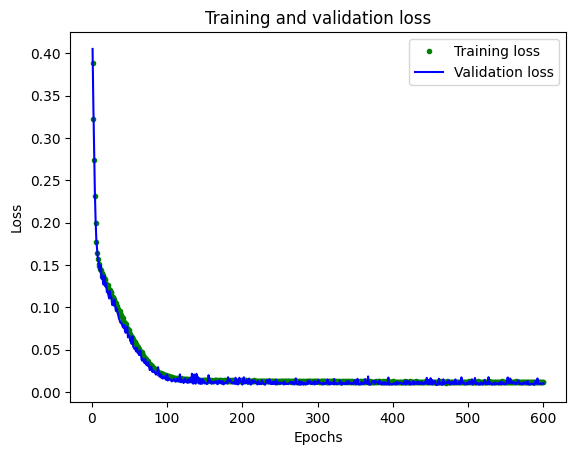

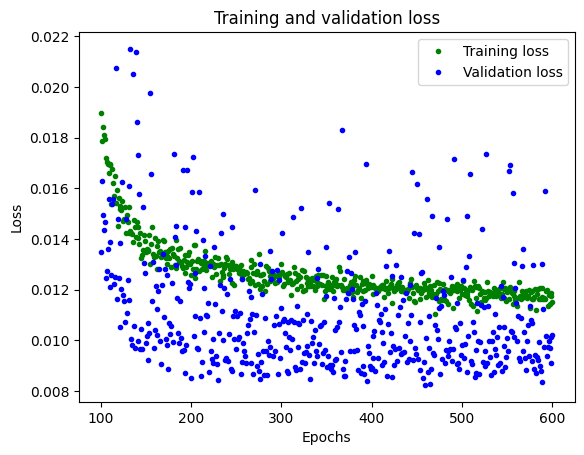

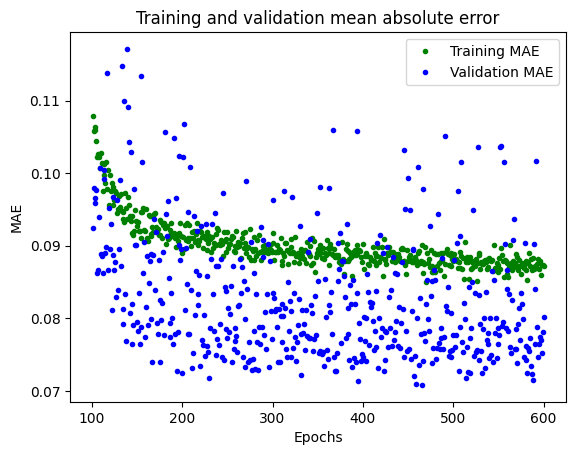

In [14]:
# 훈련과 검증 과정에서 예측값과 실제값 사이의 거리인 손실 그래프를 그린다.
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 그래프를 보기 쉽도록 처음 몇 에폭을 제외.
SKIP = 100

plt.clf()

plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()

# 예측에서 오차의 양을 측정하는 또 다른 방법인 평균 절대 오차 그래프를 그린다.
mae = history_2.history['mae']
val_mae = history_2.history['val_mae']

plt.plot(epochs[SKIP:], mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

이 그래프에서 몇 가지 흥미로운 점을 살펴볼 수 있다.

* 우리의 네트워크는 훨씬 더 빠르게 최고 정확도에 도달했다 (600 대신 200 에포크 이내).
* 전체 손실과 MAE는 이전 네트워크보다 훨씬 개선되었다.
* 전체적인 지표가 훈련보다 검증셋에 더 좋습니다. 즉, 네트워크가 과적합되지 않았다.

검증 지표가 훈련 지표보다 나은 이유는 검증 기간이 각 시대의 끝에서 계산되는 반면, 훈련 지표는 시대 전체에서 계산되므로 검증은 약간 더 오래 훈련된 모델에서 발생하기 때문이다.

모델을 좀 더 살펴보기 위해 앞에서 따로 설정한 테스트 데이터 세트와 비교하여 예측을 확인해보자.

7/7 [==============================] - 0s 1ms/step


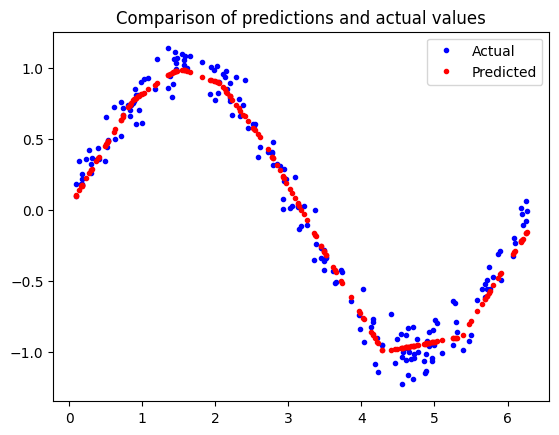

In [15]:
# 테스트 데이터셋의 손실 계산 및 출력
loss = model_2.evaluate(x_test, y_test)

# 테스트 데이터셋 기반으로 예측
predictions = model_2.predict(x_test)

# 실제값에 대한 예측 그래프
plt.clf()
plt.title('Comparison of predictions and actual values')
plt.plot(x_test, y_test, 'b.', label='Actual')
plt.plot(x_test, predictions, 'r.', label='Predicted')
plt.legend()
plt.show()

훨씬 나아졌다. 우리가 출력한 평가 지표는 모델이 테스트 데이터에서 손실과 MAE가 낮고 예측이 데이터와 시각적으로 잘 일치함을 보여준다.

모델이 완벽하지는 않다. 매끄러운 사인 곡선을 형성하지 않기 때문인데, 예를 들어,`x`가 4.2와 5.2 사이일 때 선은 거의 직선이다. 더 개선하고 싶다면 모델의 용량을 더 늘리고, 추가적인 기법을 사용하여 과적합을 막을 수도 있을 것이다.

그러나 머신러닝의 중요한 부분은 언제 종료해야 하는지를 아는 것이다. 이 정도 모델이면 LED를 깜빡이는 예제로서는 충분하다.

## TensorFlow Lite로 변환
우리는 이제 원하는 모델을 얻었다. 그러나 모델을 마이크로 컨트롤러 용 TensorFlow Lite와 함께 사용하려면 올바른 형식으로 변환하여 파일로 다운로드 해야한다. 이를 위해 [TensorFlow Lite Converter](https://www.tensorflow.org/lite/convert)를 사용해보자. 변환기는 메모리 제한된 장치에서도 사용하기 위해 특수한 형식으로 출력한다.

이 모델은 마이크로 컨트롤러에 배포될 예정이므로 가능한 작은 크기로 만들어야 한다. 모델의 크기를 줄이는 한 가지 기술로 [양자화(quantization)] (https://www.tensorflow.org/lite/performance/post_training_quantization)가 있다. 이는 모델 가중치의 정밀도를 낮추어 정확도에 큰 영향을 미치지 않으면서 메모리를 절약할 수 있다. 양자화를 통해 모델 추론에 필요한 계산이 더 간단해지기 때문에 경량화 뿐만아니라 실행속도도 빨라진다. 

TensorFlow Lite 변환기는 모델을 변환하는 동안 양자화를 적용 할 수 있다. 다음 셀에서는 모델을 두 번 변환한다. 한 번은 양자화하고 진행하고 한 번은 하지 않고 변환한다:

In [16]:
# 양자화 없이 모델을 텐서플로우 라이트 형식으로 변환
converter = tf.lite.TFLiteConverter.from_keras_model(model_2)
tflite_model = converter.convert()

# 모델을 디스크에 저장 
open("sine_model.tflite", "wb").write(tflite_model)

# 양자화하여 모델을 텐서플로우 라이트 형식으로 변환
converter = tf.lite.TFLiteConverter.from_keras_model(model_2)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

# 모델을 디스크에 저장 
open("sine_model_quantized.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\dbsgh\AppData\Local\Temp\tmp9wzcwqjv\assets


INFO:tensorflow:Assets written to: C:\Users\dbsgh\AppData\Local\Temp\tmp9wzcwqjv\assets


INFO:tensorflow:Assets written to: C:\Users\dbsgh\AppData\Local\Temp\tmp0ihcckg5\assets


INFO:tensorflow:Assets written to: C:\Users\dbsgh\AppData\Local\Temp\tmp0ihcckg5\assets


3196

## 변환된 모델 테스트
모델이 양자화 변환 후에도 여전히 정확한지 입증하기 위해 두 모델을 모두 사용하여 예측하고 테스트 결과와 비교해보자.

C:\Users\dbsgh\AppData\Local\Temp\ipykernel_17552\1387564998.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sine_model_predictions[i] = sine_model_output()[0]
C:\Users\dbsgh\AppData\Local\Temp\ipykernel_17552\1387564998.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sine_model_quantized_predictions[i] = sine_model_quantized_output()[0]


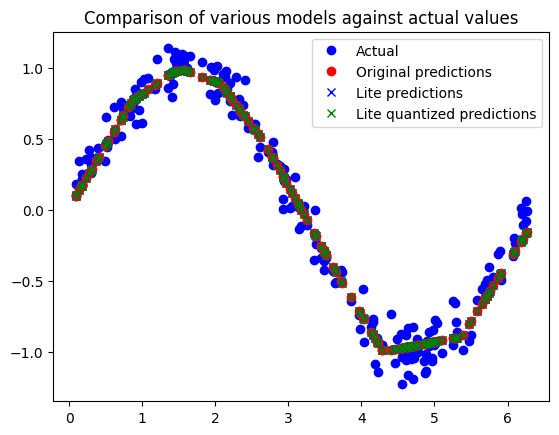

In [17]:
# 각 모델에 대한 인터프리터 인스턴스화.
sine_model = tf.lite.Interpreter('sine_model.tflite')
sine_model_quantized = tf.lite.Interpreter('sine_model_quantized.tflite')

# 각 모델에 대한 메모리 할당
sine_model.allocate_tensors()
sine_model_quantized.allocate_tensors()

# 입력과 결과 텐서에 대한 인덱스 가져오기
sine_model_input = sine_model.tensor(sine_model.get_input_details()[0]["index"])
sine_model_output = sine_model.tensor(sine_model.get_output_details()[0]["index"])
sine_model_quantized_input = sine_model_quantized.tensor(sine_model_quantized.get_input_details()[0]["index"])
sine_model_quantized_output = sine_model_quantized.tensor(sine_model_quantized.get_output_details()[0]["index"])

# 결과를 저장하기 위한 배열 생성
sine_model_predictions = np.empty(x_test.size)
sine_model_quantized_predictions = np.empty(x_test.size)

# 각 값에 대해 각 모델의 인터프리터를 실행하고 결과를 배열에 저장
for i in range(x_test.size):
  sine_model_input().fill(x_test[i])
  sine_model.invoke()
  sine_model_predictions[i] = sine_model_output()[0]

  sine_model_quantized_input().fill(x_test[i])
  sine_model_quantized.invoke()
  sine_model_quantized_predictions[i] = sine_model_quantized_output()[0]

# 데이터가 어떻게 정렬되는지 확인
plt.clf()
plt.title('Comparison of various models against actual values')
plt.plot(x_test, y_test, 'bo', label='Actual')
plt.plot(x_test, predictions, 'ro', label='Original predictions')
plt.plot(x_test, sine_model_predictions, 'bx', label='Lite predictions')
plt.plot(x_test, sine_model_quantized_predictions, 'gx', label='Lite quantized predictions')
plt.legend()
plt.show()


그래프에서 원래 모델, 변환된 모델, 양자화 된 모델에 대한 예측이 모두 구별할 수 없을 정도로 차이가 없는 것을 확인할 수 있다. 이를통해 양자화된 모델을 사용하는 것이 큰 무리가 없음을 알 수 있다. 

다음으로, 모델크기는 얼마나 차이나는지 알아보자.

In [21]:
import os

# 모델 사이즈 출력
basic_model_size = os.path.getsize("sine_model.tflite")
print("Basic model is %d bytes" % basic_model_size)
quantized_model_size = os.path.getsize("sine_model_quantized.tflite")
print("Quantized model is %d bytes" % quantized_model_size)
difference = basic_model_size - quantized_model_size
print("Difference is %d bytes" % difference)




Basic model is 3192 bytes
Quantized model is 3196 bytes
Difference is -4 bytes


## CC파일로 변환하기.(Python)

In [22]:
# 파일을 읽고, C 소스 파일 형태로 변환하는 함수
def convert_to_c_source(file_path, output_file):
    with open(file_path, 'rb') as f:
        content = f.read()
        with open(output_file, 'w') as of:
            of.write(f"unsigned char model[] = {{\n")
            for i in range(0, len(content), 12):
                byte_str = ', '.join([f"0x{content[j]:02x}" for j in range(i, min(i+12, len(content)))])
                of.write(f"  {byte_str},\n")
            of.write(f"}};\nunsigned int model_len = {len(content)};\n")

# 파일 변환 실행
convert_to_c_source("sine_model_quantized.tflite", "sine_model_quantized.cc")

# 변환된 파일 출력
with open("sine_model_quantized.cc", 'r') as f:
    print(f.read())

unsigned char model[] = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00,
  0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00, 0x0c, 0x00, 0x00, 0x00,
  0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00,
  0x94, 0x00, 0x00, 0x00, 0xec, 0x00, 0x00, 0x00, 0x08, 0x07, 0x00, 0x00,
  0x18, 0x07, 0x00, 0x00, 0x28, 0x0c, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x10, 0x00, 0x00, 0x00, 0x00, 0x00, 0x0a, 0x00,
  0x10, 0x00, 0x0c, 0x00, 0x08, 0x00, 0x04, 0x00, 0x0a, 0x00, 0x00, 0x00,
  0x0c, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x38, 0x00, 0x00, 0x00,
  0x0f, 0x00, 0x00, 0x00, 0x73, 0x65, 0x72, 0x76, 0x69, 0x6e, 0x67, 0x5f,
  0x64, 0x65, 0x66, 0x61, 0x75, 0x6c, 0x74, 0x00, 0x01, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x94, 0xff, 0xff, 0xff, 0x09, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x07, 0x00, 0x00, 0x00, 0x64, 0x65, 0x6e, 0x73,
  0x65, 0x5f, 0x34, 0x00, 0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00,
  0x86, 0xf9

양자화된 모델은 원래 버전보다 16 바이트 작다. 약 2.6킬로 바이트 크기의 모델은 이미 너무 작아서 가중치가 전체 크기의 작은 부분만 차지하므로 양자화가 거의 영향을 미치지 않은 것이다. 

더 복잡한 모델의 경우, 더 많은 가중치를 가지므로 양자화로 인한 공간 절약이 훨씬 높아져 최대 4배까지 모델 크기를 줄일 수 있다.

어쨌든, 양자화 된 모델은 원래 버전보다 실행시간이 덜 걸리며, 이는 마이크로 컨트롤러에서 중요한 부분이다.

## C 파일에 쓰기 (리눅스)
마이크로 컨트롤러 용 TensorFlow Lite와 함께 사용할 모델을 준비하는 마지막 단계는 모델을 C 소스 파일로 변환하는 것이다. 이 형식의 예제는 [`hello_world / sine_model_data.cc`](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/micro/examples/hello_world/sine_model_data.cc)에서 확인할 수 있다.

이를 위해 [`xxd`](https://linux.die.net/man/1/xxd)라는 명령행 유틸리티를 사용할 수 있다. 다음 셀은 양자화된 모델에서 xxd를 실행하고 출력한다.

In [19]:
# xxd를 사용할 수 없을 경우, 설치한다.
!apt-get -qq install xxd
# 파일을 C 소스파일로 저장 
!xxd -i sine_model_quantized.tflite > sine_model_quantized.cc
# 소스파일을 출력
!cat sine_model_quantized.cc

'apt-get'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.
'xxd'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


'cat'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


이 출력값을 복사하여 프로젝트의 소스 코드에 붙여 넣거나이 Colab 왼쪽의 메뉴를 사용하여 파일을 다운로드 할 수 있다.
